## Cleo Product Analyst Exercise

In [1]:
import psycopg2
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import nbconvert
from IPython.display import HTML, display, Math, Latex, Image
import sqlite3

In [2]:
HTML('''<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML' async></script>''')
HTML('''
<script>code_show=true; function code_toggle(){if (code_show){$('div.input').hide();}else{$('div.input').show();}code_show=!code_show}$( document ).ready(code_toggle);</script>
The RAW CODE for this IPython notebook is by default hidden for easier reading.</BR>
</BR>
---> RAW CODE TOGGLE: <a href="javascript:code_toggle()">CLICK HERE</a>''')

## Part 1: 
* 1.1 Import Data and Metric Definitions
* 1.2 Setup Metrics


### 1.1.1 Import  and Clean User and Activity Data
Query the following data to analyse retention
Table 1 = cleo_users.csv
Table 2 = cleo_user_activity.csv

New Fields added in SQL  
* activity = Count of the number of times that user was active (int)
* budget_created = Did the user id create a budget 
* autosave_created  = Did the user id setup auto save
* subscription_created  = Did the user id create a paid subscription

### 1.1.2 SQL Query Used:
    SELECT DISTINCT
        cu.id AS id,
        DATE(substr(created_at, 7) || "-" || substr(created_at,4,2) || "-" || substr(created_at, 1,2)) AS signup_date,
        DATE(cua.active_date) AS active_date,
        COUNT(cua.active_date) over (partition by cu.id) as activity,
        cu.user_country AS user_country,
        cu.age AS age,
        cu.campaign_source AS campaign_source,
        cu.device AS device,
        cu.budget_created_at AS budget_created_at,
        cu.autosave_created_at AS autosave_created_at,
        cu.subscription_created_at AS subscription_created_at,
        CASE WHEN (cu.budget_created_at IS NULL) THEN 0 ELSE 1 END AS budget_created,
        CASE WHEN (cu.autosave_created_at IS NULL) THEN 0 ELSE 1 END AS autosave_created,
        CASE WHEN (cu.subscription_created_at IS NULL) THEN 0 ELSE 1 END AS subscription_created
        FROM cleo_users cu
      JOIN cleo_user_activity cua
    ON cu.id = cua.user_id;

In [3]:
#read the CSVs
cleo_df1 = pd.read_csv('cleo_users.csv')
cleo_df2 = pd.read_csv('cleo_user_activity.csv')

In [4]:
#connect to a database
#conn=psycopg2.connect("dbname='dbo1' user='dbuser' host='localhost' password='dbpass'")
conn = sqlite3.connect("cleo_data.db") #if the db does not exist, this creates a file in the current directory
#store your table in the database:
cleo_df1.to_sql('cleo_users', conn)
cleo_df2.to_sql('cleo_user_activity', conn)

In [5]:
#read a SQL Query out of your database and into a pandas dataframe
#sql_string = 'SELECT * FROM experimentdoe02_table'

sql_string = """
    SELECT DISTINCT
        cu.id AS id,
        DATE(substr(created_at, 7) || "-" || substr(created_at,4,2) || "-" || substr(created_at, 1,2)) AS signup_date,
        DATE(cua.active_date) AS active_date,
        COUNT(cua.active_date) over (partition by cu.id) as activity,
        cu.user_country AS user_country,
        cu.age AS age,
        cu.campaign_source AS campaign_source,
        cu.device AS device,
        cu.budget_created_at AS budget_created_at,
        cu.autosave_created_at AS autosave_created_at,
        cu.subscription_created_at AS subscription_created_at,
        CASE WHEN (cu.budget_created_at IS NULL) THEN 0 ELSE 1 END AS budget_created,
        CASE WHEN (cu.autosave_created_at IS NULL) THEN 0 ELSE 1 END AS autosave_created,
        CASE WHEN (cu.subscription_created_at IS NULL) THEN 0 ELSE 1 END AS subscription_created
        FROM cleo_users cu
      JOIN cleo_user_activity cua
    ON cu.id = cua.user_id;
"""
cleo_data_df = pd.read_sql(sql_string, conn)


In [6]:
cleo_data_df.head()

,id,signup_date,active_date,activity,user_country,age,campaign_source,device,budget_created_at,autosave_created_at,subscription_created_at,budget_created,autosave_created,subscription_created
0,856160,2019-01-01,2019-01-01,94,GB,21,Influencer,messenger,None,None,None,0,0,0
1,856160,2019-01-01,2019-01-02,94,GB,21,Influencer,messenger,None,None,None,0,0,0
2,856160,2019-01-01,2019-01-06,94,GB,21,Influencer,messenger,None,None,None,0,0,0
3,856160,2019-01-01,2019-01-08,94,GB,21,Influencer,messenger,None,None,None,0,0,0
4,856160,2019-01-01,2019-01-09,94,GB,21,Influencer,messenger,None,None,None,0,0,0


In [7]:
cleo_data_df['signup_date'] = pd.to_datetime(cleo_data_df['signup_date'])
cleo_data_df['active_date'] = pd.to_datetime(cleo_data_df['active_date'])
cleo_data_df['budget_created_at'] = pd.to_datetime(cleo_data_df['budget_created_at'])
cleo_data_df['autosave_created_at'] = pd.to_datetime(cleo_data_df['autosave_created_at'])
cleo_data_df['subscription_created_at'] = pd.to_datetime(cleo_data_df['subscription_created_at'])
cleo_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431311 entries, 0 to 431310
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       431311 non-null  int64         
 1   signup_date              431311 non-null  datetime64[ns]
 2   active_date              431311 non-null  datetime64[ns]
 3   activity                 431311 non-null  int64         
 4   user_country             431311 non-null  object        
 5   age                      431311 non-null  int64         
 6   campaign_source          431311 non-null  object        
 7   device                   431311 non-null  object        
 8   budget_created_at        256998 non-null  datetime64[ns]
 9   autosave_created_at      64094 non-null   datetime64[ns]
 10  subscription_created_at  140078 non-null  datetime64[ns]
 11  budget_created           431311 non-null  int64         
 12  autosave_created

### 1.2 Setup Metrics And Definitions
Create a new column called seniority which indicates how old was the user on that day that they visited the app

* seniority = Activity Date - Sign-up Date -> in days (int)
* seniority_m = Activity Date  - Sign-up Date -> in months (int)
* signup_m_y = Month and Year of Sign-up date in order to group by YYYY-MM for creating retention heatmap

In [8]:
cleo_data_df['seniority'] = (cleo_data_df['active_date'] - cleo_data_df['signup_date']).dt.days + 1

In [9]:
print('Earliest Activity Date in the data is:')
min(cleo_data_df['active_date'])
print('Latest Activity Date in the data is:')
max(cleo_data_df['active_date'])

Earliest Activity Date in the data is:
Latest Activity Date in the data is:


Timestamp('2020-02-07 00:00:00')

In [10]:
print('Earliest Sign-up Date in the data is:')
min(cleo_data_df['signup_date'])
print('Latest Sign-up Date in the data is:')
max(cleo_data_df['signup_date'])

Earliest Sign-up Date in the data is:
Latest Sign-up Date in the data is:


Timestamp('2019-08-31 00:00:00')

Data covers a large period of time and daily granularity makes the graph plot very difficult to read, therefore we shall use retention over monthly period, instead of daily.

#### 1.2.1 Create a period column based on the Sign-up Date¶
Since we're doing monthly cohorts, we'll be looking at the total monthly behavior of users. Therefore, we don't want daily data (right now). Create a new column called signup_m_y which is the year and month in which the user signed up.

    cleo_data_df['signup_m_y'] = pd.to_datetime(cleo_data_df['signup_date']).dt.to_period('M')

In [11]:
cleo_data_df['signup_m_y'] = pd.to_datetime(cleo_data_df['signup_date']).dt.to_period('M')

#### 1.2.2 Determine the user's cohort group (based on when they signed up)
Create a new column called seniority_m which indicates how old was the user on that day that they visited the app

    cleo_data_df['seniority_m'] = ((cleo_data_df['active_date'] - cleo_data_df['signup_date']) / np.timedelta64(1, 'M')).astype(int)+1

In [12]:
cleo_data_df['seniority_m'] = ((cleo_data_df['active_date'] - cleo_data_df['signup_date']) / np.timedelta64(1, 'M')).astype(int)+1

In [13]:
cleo_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431311 entries, 0 to 431310
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       431311 non-null  int64         
 1   signup_date              431311 non-null  datetime64[ns]
 2   active_date              431311 non-null  datetime64[ns]
 3   activity                 431311 non-null  int64         
 4   user_country             431311 non-null  object        
 5   age                      431311 non-null  int64         
 6   campaign_source          431311 non-null  object        
 7   device                   431311 non-null  object        
 8   budget_created_at        256998 non-null  datetime64[ns]
 9   autosave_created_at      64094 non-null   datetime64[ns]
 10  subscription_created_at  140078 non-null  datetime64[ns]
 11  budget_created           431311 non-null  int64         
 12  autosave_created

#### 1.2.3 Rollup data into cohorts
Since we're looking at monthly cohorts, we need to aggregate users by their sign-up month and seniority of their activity

In [14]:
group = cleo_data_df.groupby(['signup_m_y', 'seniority_m'])

In [15]:
cohort_data = group['id'].size()

In [16]:
cohort_data = cohort_data.reset_index()
cohort_data

,signup_m_y,seniority_m,id
0,2019-01,1,26115
1,2019-01,2,12516
2,2019-01,3,10030
3,2019-01,4,8892
4,2019-01,5,6973
...,...,...,...
79,2019-08,3,3031
80,2019-08,4,1947
81,2019-08,5,1251
82,2019-08,6,775


#### 1.2.4 Pivot the data to calculate user counts
Create a pivot table with
- signup as the rows - each row respresenting a given cohort of users who signed up in a specific month
- seniority as the columns - this allows us to see how much user activity decays for a given cohort by looking from left to right for a specific row:

In [17]:
cohort_counts = cohort_data.pivot(index='signup_m_y', columns='seniority_m', values='id')
cohort_counts

seniority_m,1,2,3,4,5,6,7,8,9,10,11,12,13,14
signup_m_y,,,,,,,,,,,,,,
2019-01,26115.0,12516.0,10030.0,8892.0,6973.0,5889.0,5037.0,3342.0,2548.0,3046.0,2412.0,2180.0,1345.0,56.0
2019-02,19801.0,10125.0,9080.0,6527.0,5766.0,4390.0,3377.0,2339.0,2634.0,2341.0,1662.0,1388.0,28.0,NaN
2019-03,24650.0,15252.0,11107.0,8756.0,6972.0,5445.0,3784.0,3711.0,3141.0,2346.0,1878.0,125.0,NaN,NaN
2019-04,15967.0,8716.0,6865.0,5032.0,3806.0,2559.0,2418.0,1862.0,1421.0,1165.0,51.0,NaN,NaN,NaN
2019-05,8793.0,5232.0,3955.0,2691.0,1947.0,1446.0,1199.0,863.0,629.0,49.0,NaN,NaN,NaN,NaN
2019-06,21372.0,10008.0,6710.0,4081.0,2947.0,2030.0,1646.0,980.0,24.0,NaN,NaN,NaN,NaN,NaN
2019-07,14760.0,7317.0,4854.0,3041.0,2332.0,1424.0,983.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,11048.0,4999.0,3031.0,1947.0,1251.0,775.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
base = cohort_counts[1]

#### 1.2.5 Calculate Absolute Retention Rate
Apply the divide method to our cohort_counts, dividing it by the base number of users in column 1 of the cohort
This gives a set of raw/absolute numbers for retention:

In [19]:
retention = cohort_counts.divide(base, axis=0).round(3)
retention

seniority_m,1,2,3,4,5,6,7,8,9,10,11,12,13,14
signup_m_y,,,,,,,,,,,,,,
2019-01,1.0,0.479,0.384,0.340,0.267,0.226,0.193,0.128,0.098,0.117,0.092,0.083,0.052,0.002
2019-02,1.0,0.511,0.459,0.330,0.291,0.222,0.171,0.118,0.133,0.118,0.084,0.070,0.001,NaN
2019-03,1.0,0.619,0.451,0.355,0.283,0.221,0.154,0.151,0.127,0.095,0.076,0.005,NaN,NaN
2019-04,1.0,0.546,0.430,0.315,0.238,0.160,0.151,0.117,0.089,0.073,0.003,NaN,NaN,NaN
2019-05,1.0,0.595,0.450,0.306,0.221,0.164,0.136,0.098,0.072,0.006,NaN,NaN,NaN,NaN
2019-06,1.0,0.468,0.314,0.191,0.138,0.095,0.077,0.046,0.001,NaN,NaN,NaN,NaN,NaN
2019-07,1.0,0.496,0.329,0.206,0.158,0.096,0.067,0.003,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,1.0,0.452,0.274,0.176,0.113,0.070,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 Plot Retention Rate Percentage Over time (left to right) segmented by cohort (month of signup)

Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. 

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first sign-up, as it is based on everyone in the cohort signed-up who signed up that month (their month 1).

This plot shows that retention rates were better for users who signed up in March - May of last year, possibly due to Marketing Campaignn, release of product features or push notifications in the user's second month of using Cleo.
However, by their third month of using Cleo, their retention rate decayed to the same level as the other cohorts (~30-35%), meaning the boost in activity for these cohorts was short lived.

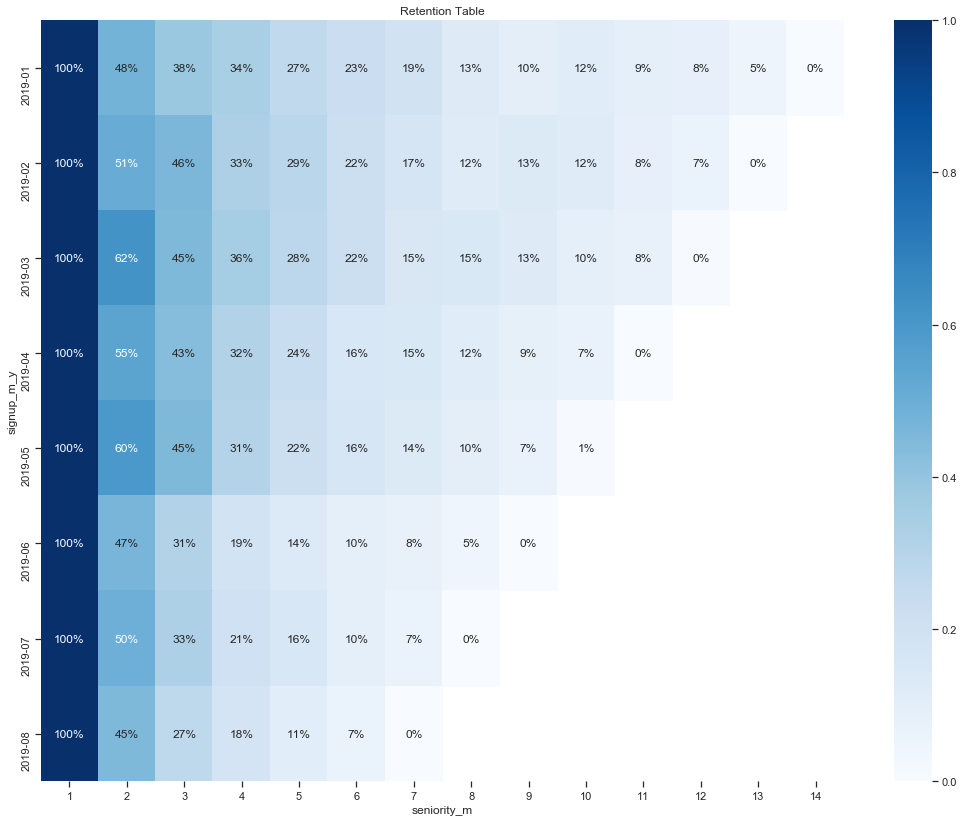

In [20]:
plt.figure(figsize=(18,14))
plt.title('Retention Table')
ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1,cmap='Blues')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()
fig.savefig("Retention_Rate.png")
plt.show()

## Part 2 - Segmentation

#### Part 2.1 - simple user segments
Review the amount that user activity decays by over time, by segment, including:
* 2.1.1 user_country
* 2.1.2 age
* 2.1.3 campaign_source
* 2.1.4 device

The Data are aggregated across cohorts to show how overall activity decays over time for each user segment, regardless of sign-up month.
With more time, I would want to dive into these segments more deeply, and see if they are a predictor for user activity or subscription rates.
It would also be beneficial to run an RFM analysis( RFM stands for Recency - Frequency - Monetary Value) 
similar to the following: https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

In [21]:
#cleo_data_df.info()

In [22]:
#all3group = cleo_data_df.groupby(['budget_created','autosave_created','subscription_created'])['id'].size().unstack('budget_created').fillna(0)
#all3group.plot(kind='bar', stacked=True)

In [23]:
#all3group2 = cleo_data_df.groupby(['budget_created','autosave_created','subscription_created'])['id'].size().unstack('subscription_created').fillna(0)
#all3group2.plot(kind='bar', stacked=True)

#### 2.1.1 user_country
More users sign up in the UK then the US
Churn of users in the US is noticeably faster, fewer US users are returning after 6months

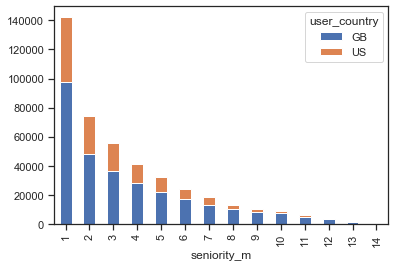

In [24]:
activitygroup4 = cleo_data_df.groupby(['seniority_m','user_country'])['id'].size().unstack('user_country').fillna(0)
activitygroup4.plot(kind='bar', stacked=True)

#### 2.1.2 age
Users Under 35 and Under 25 are the largest user groups to sign up
These users also churn less than the other groups.

In [25]:
newdf = cleo_data_df.copy()
agecategory = pd.cut(newdf.age,bins=[18,25,35,45,55,65,75],labels=['<25','<35','<45','<55','<65','<75'])
newdf.insert(8,'AgeGroup',agecategory)

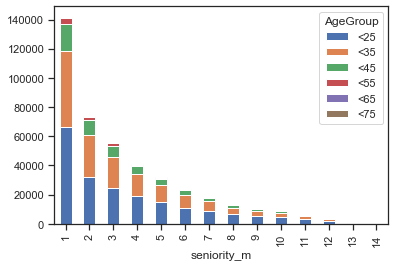

In [26]:
activitygroup2 = newdf.groupby(['seniority_m','AgeGroup'])['id'].size().unstack('AgeGroup').fillna(0)
activitygroup2.plot(kind='bar', stacked=True) 

#### 2.1.3 campaign_source
This plot shows that in the first month of sign up, most users are influencers
However, churn in influences is very high in the first month after sign up
Retention after 6 months is higher in the other 3 campaign source groups

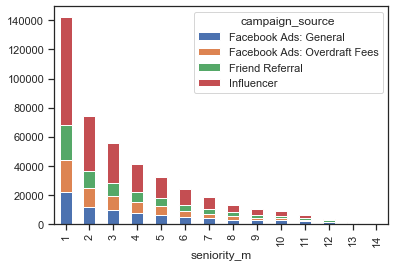

In [27]:
activitygroup1 = cleo_data_df.groupby(['seniority_m','campaign_source'])['id'].size().unstack('campaign_source').fillna(0)
activitygroup1.plot(kind='bar', stacked=True)

#### 2.1.4 device
Most users sign up on messenger
Retention for ios and messenger users is higher

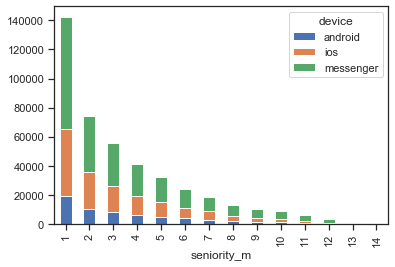

In [28]:
activitygroup3 = cleo_data_df.groupby(['seniority_m','device'])['id'].size().unstack('device').fillna(0)
activitygroup3.plot(kind='bar', stacked=True) 

In [29]:
cleo_data_df['subscribe_level'] = cleo_data_df['budget_created'].astype(str) + cleo_data_df['autosave_created'].astype(str) + cleo_data_df['subscription_created'].astype(str) 

#### Part 3 - Subscription creation segments

Finally, take a look at how activity over time also varies by the subscription level a user has:
* Do they have a budget setup, and auto saving, and a paid subscription? or none?


1. Look at the number of users in each group: 
* 3.1.1 budget_created
* 3.1.2 autosave_created
* 3.1.3 subscription_created

  
2. Look at how the size of the groups changes as the activity in each cohort decays


#### 2.2.1 budget_created
This graphs shows that a lot of users have created a budget

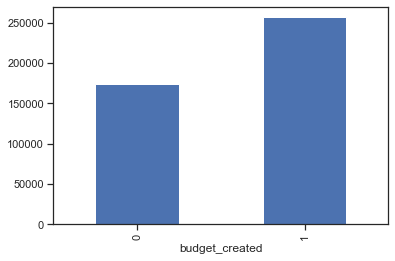

In [30]:
budgetgroup = cleo_data_df.groupby(['budget_created'])
budget = budgetgroup['id'].size()
budget.plot(kind='bar')

#### 2.2.1 autosave_created
This indicates very few users have autosave setup

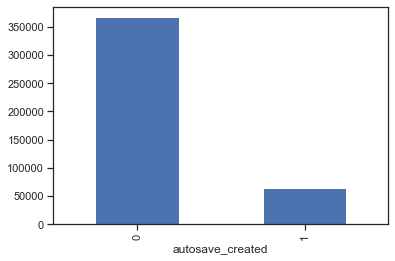

In [31]:
autosavegroup = cleo_data_df.groupby(['autosave_created',])
autosave = autosavegroup['id'].size()
autosave.plot(kind='bar')

#### 2.2.3 subscription_created
This indicates fewer users have a paid subscription

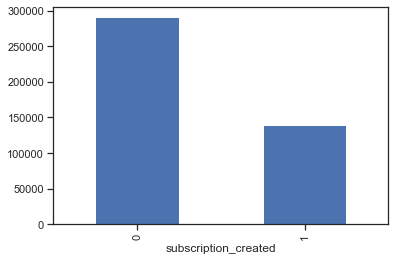

In [32]:
subscriptiongroup = cleo_data_df.groupby(['subscription_created'])
subscription = subscriptiongroup['id'].size()
subscription.plot(kind='bar')

#### Part 3.2 - Subscription level retention

2. Look at how the size of the groups changes as the activity in each cohort decays

The Subscription status for users were aggregated based on the following groups:

In [33]:
cleo_data_df['subscribe_level'] = cleo_data_df['budget_created'].astype(str) + cleo_data_df['autosave_created'].astype(str) + cleo_data_df['subscription_created'].astype(str) 
cleo_data_df = cleo_data_df.replace({'subscribe_level' : { '000' : '0_None', '100' : '1_Budget', '110' : '2_Budget,Auto' , '001' : '4_Subscribed' , '010' : '3_Autosave' , '011' : '5_Auto,Subscription' , '101' : '6_Budget,Subscribed' , '111' : '7_All' }})
print('Subscription Category labels:')
cleo_data_df['subscribe_level'].unique().tolist()

Subscription Category labels:


['0_None',
 '1_Budget',
 '2_Budget,Auto',
 '4_Subscribed',
 '3_Autosave',
 '5_Auto,Subscription',
 '6_Budget,Subscribed',
 '7_All']

#### 3.2 How does subscription level change after initial sign-up?

* Relatively few users sign-up with a paid subscription
* A large group of user sign-up with a budget or autosave+busget setup
* Users with a great level of subscription appear to have better retention rates then the other groups
* However, overall users with no features enabled or just budget setup make up the largest proportion of users in each month of seniority.

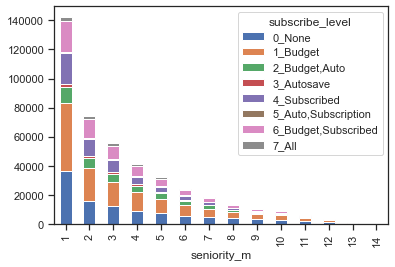

In [34]:
activitygroup3 = cleo_data_df.groupby(['seniority_m','subscribe_level'])['id'].size().unstack('subscribe_level').fillna(0)
activitygroup3.plot(kind='bar', stacked=True) 

In [35]:
#all3group = cleo_data_df.groupby(['budget_created','autosave_created','subscription_created'])['id'].size().unstack('budget_created').fillna(0)
#all3group.plot(kind='bar', stacked=True)